In [15]:
import csv
from pathlib import Path

In [75]:
def get_terms(file_path: Path, delimiter=","):
    with open(file_path, "r") as f:
        rows = list(csv.reader(f, delimiter=delimiter))
    if len(rows[0]) > 3:
        rows = [row[0:3] for row in rows]
    terms_map = {
        key: [v1, v2.lower().split("|")] for (key, v1, v2) in rows
    }
    terms = {
        term.lower() for group in [row[2].split("|") for row in rows] for term in group
    }
    return terms_map, terms

In [44]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

### Disease terms

This one is unfair because BioWordLists only includes cancer terms

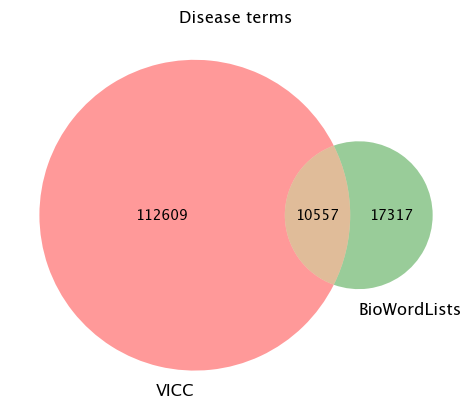

In [142]:
vicc_diseases_min_map, vicc_diseases_min_terms = get_terms(
    "terms_diseases_min.csv"
)
vicc_diseases_map, vicc_diseases_terms = get_terms("terms_diseases_full.csv")
wl_diseases_map, wl_diseases_terms = get_terms("biowordlists/terms_cancers.tsv", "\t")

venn2(subsets=(
    len(vicc_diseases_min_terms - wl_diseases_terms),
    len(wl_diseases_terms - vicc_diseases_min_terms),
    len(wl_diseases_terms & vicc_diseases_min_terms)
), set_labels=("VICC", "BioWordLists"))
plt.title("Disease terms")
plt.show()

---

What kinds of cancer terms aren't in the VICC disease normalizer?

In [77]:
not_in_bwl =  wl_diseases_terms - vicc_diseases_min_terms
import random
random.seed(42)
{i for i in not_in_bwl if random.random() < 0.003}  # random sample

{'adult choroid plexus tumors',
 'basophilic carcinomas',
 'bronchiolar adenocarcinoma',
 'carcinoma of scrotum (diagnosis)',
 'cardiac neopl',
 'darier ferrand tumors',
 'extrahepatic bile duct clear cell adenocarcinomas',
 'fallopian tube transitional cell cancers',
 'familiar wilms tumors',
 'fibrolamellar hepatocellular carcinomas',
 'follicular ca - well diff',
 'immunoblastic lymphadenopathies',
 'kidney adenocarcinomas',
 'localized peripheral neuroectodermal tumor',
 'mal neo cerebellum nos',
 'malig neop splenic flex colon',
 'malig tumour pancreatic duct',
 'malignant gallbladder neoplasms',
 'malignant granular cell tumour (disorder)',
 'malignant mast cell tumor',
 'malignant mixed tumor of the uterine corpus',
 'malignant neoplasm of body of uterus (disorder)',
 'malignant neoplasm of chest wall (disorder)',
 'malignant neoplasm of cranial nerves nos (disorder)',
 'malignant prolactin secreting pituitary tumor',
 'malignant tumour of large intestine',
 'malignant tumour of

Points of interest:

* Abbreviations: `cardiac neopl`, `mal neo cerebellum nos`
* Plural terms: `kidney adenocarcinoma` will normalize, but `kidney adenocarcinomas` won't

---
**What kinds of terms aren't in BioWordLists?**

In [78]:
not_in_bwl = vicc_diseases_min_terms - wl_diseases_terms
import random
random.seed(42)
{i for i in not_in_bwl if random.random() < 0.001}

{'10p12p11 microdeletion syndrome',
 '46, xy cgd',
 'abnormal origin or aberrant course of coronary artery',
 'acromesomelic dysplasia',
 'adenomatous polyp of cervix',
 'adult-onset leukoencephalopathy with axonal spheroids and pigmented glia',
 'alkhurma hemorrhagic fever',
 'ann arbor stage iii follicular lymphoma',
 'aortic aneurysm of unspecified site, ruptured',
 'atelectasis',
 'b-cell small lymphocytic lymphoma refractory',
 'bart-pumphrey syndrome',
 'basal cell ameloblastoma',
 'bbbg1',
 'benign melanocytic nevus of skin',
 'benign neoplasm of spleen',
 'benign neoplasm of the prostate',
 'cass',
 'chronic obstructive asthma with status asthmaticus',
 'cog4-cdg',
 'colorectal tubulovillous adenoma',
 'combined immunodeficiency with impaired immunity to hhv-8',
 'cone-rod dystrophy caused by mutation in pitpnm3',
 'congenital intestinal disease due to an enzymatic defect',
 'craniosynostosis with lid anomalies',
 'cutaneous hypersensitivity vasculitis',
 'cutaneous lobomycosis

Points of interest:
* Gene names: `ofd14`, `spd2` -- thanks OMIM
* Some oncologic terms! `benign neoplasm of spleen`, `benign neoplasm of the prostate`
* Oncologic terms with staging: `stage ii renal pelvis and ureter carcinoma` etc
* Oncologic terms with grading: `undifferentiated carcinoma of the submandibular gland`
* Absurdly specific terms: `urinary bladder urothelium papillary epithelial neoplasm`

### Drug terms

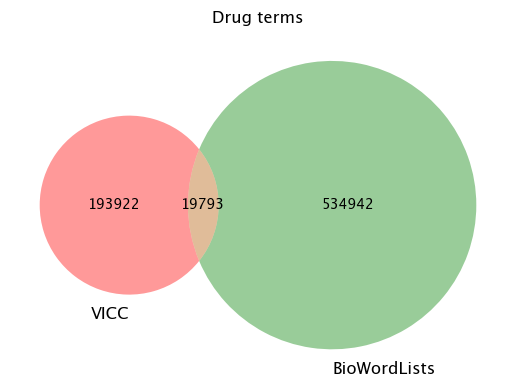

In [79]:
vicc_drugs_min_map, vicc_drugs_min_terms = get_terms(
    "terms_drugs_min.csv"
)
vicc_drugs_map, vicc_drugs_terms = get_terms("terms_drugs_full.csv")
wl_drugs_map, wl_drugs_terms = get_terms("biowordlists/terms_drugs.tsv", "\t")

venn2(subsets=(
    len(vicc_drugs_min_terms - wl_drugs_terms),
    len(wl_drugs_terms - vicc_drugs_min_terms),
    len(wl_drugs_terms & vicc_drugs_min_terms)
), set_labels=("VICC", "BioWordLists"))
plt.title("Drug terms")
plt.show()

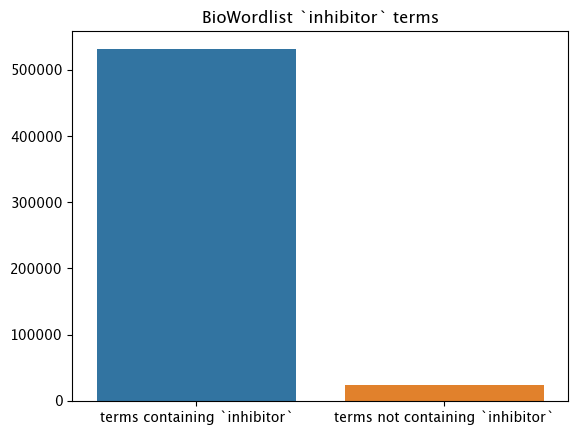

In [108]:
inh_terms = {t for t in wl_drugs_terms if "inhibitor" in t}
non_inh_terms = {t for t in wl_drugs_terms if "inhibitor" not in t}

import seaborn as sns

plot = sns.barplot(
    x=[
        "terms containing `inhibitor`", "terms not containing `inhibitor`", 
    ],
    y=[len(inh_terms), len(non_inh_terms)]
)

plot.set(title="BioWordlist `inhibitor` terms")
plt.show()

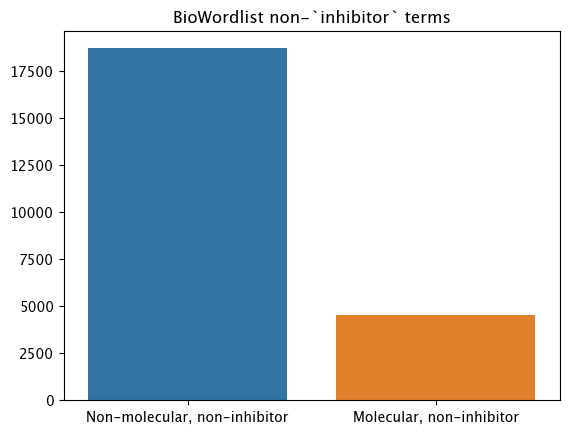

In [130]:
import re
chem_terms = {i for i in non_inh_terms if re.match(r"[^ ]*\(.*\)[^ ]", i) or re.match(".*-.*-.*-.*", i)}
non_chem_terms = non_inh_terms - chem_terms
plot = sns.barplot(
    x=[
        "Non-molecular, non-inhibitor", "Molecular, non-inhibitor", 
    ],
    y=[len(non_chem_terms), len(chem_terms)]
)

plot.set(title="BioWordlist non-`inhibitor` terms")
plt.show()


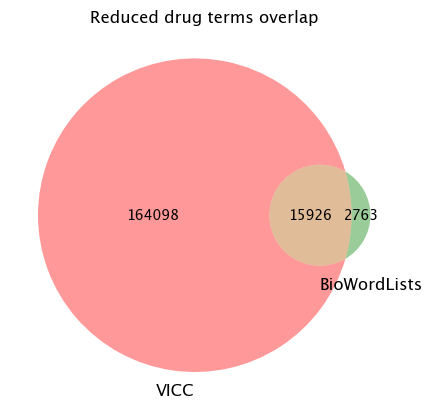

In [131]:
from typing import Set

def reduce_drug_terms(drug_term_set: Set[str]) -> Set[str]:
    return {
        i for i in drug_term_set
        if not (
            re.match(r"[^ ]*\(.*\)[^ ]", i)
            or re.match(".*-.*-.*-.*", i)
        )
        and "inhibitor" not in i
    }

vicc_drugs_reduced = reduce_drug_terms(vicc_drugs_min_terms)
wl_drugs_reduced = reduce_drug_terms(wl_drugs_terms)


venn2(subsets=(
    len(vicc_drugs_reduced - wl_drugs_reduced),
    len(wl_drugs_reduced - vicc_drugs_reduced),
    len(wl_drugs_reduced & vicc_drugs_reduced)
), set_labels=("VICC", "BioWordLists"))
plt.title("Reduced drug terms overlap")
plt.show()

In [133]:
random.seed(42)
[i for i in wl_drugs_reduced & vicc_drugs_reduced if random.random() < 0.005]

['fluocytosine',
 'istodax®',
 'drx187',
 'glutamic acid 5-amide',
 'heparin sodium',
 'brl-2039',
 'yasmin',
 'ci-880',
 'r-4749',
 'teriflunomida',
 'sterilon',
 'delta-hydrocortisone',
 'methopyrimazole',
 'cn 35355',
 'dilantin®',
 'phentermine',
 'dimethyl sulfur oxide',
 'ibrutinib',
 'adapine',
 'trimébutine',
 'trecator',
 'paucimycinum',
 'homatropine methylbromide',
 'paramethasone',
 'sq-14225',
 'anplag®',
 'butanedioic acid',
 'parabromodylamine',
 'betotastine',
 'acetyl-digitoxin-alpha',
 'astenile',
 'menotropins',
 'metamizol',
 'caco3',
 'propiomazin',
 'nordazepam',
 'vedaclidine',
 'adrenor',
 'phenylic acid',
 'rhodialothan',
 'maygace',
 'senshio',
 'gatifloxacinum',
 'hydrochlorothiazide / lisinopril',
 'nifedipine',
 'brodalumab',
 'promegapoietin',
 'uk 116044',
 'antiberiberi factor',
 'dipivéfrine',
 'mcn-jr-6218',
 'isotretinoin',
 'e 420',
 'ilotycin',
 'albac 50',
 'fluocinolone 16,17-acetonide',
 'skelaxin',
 'tribavirin',
 '4pba',
 '6-alpha-methylcompact

### Gene terms

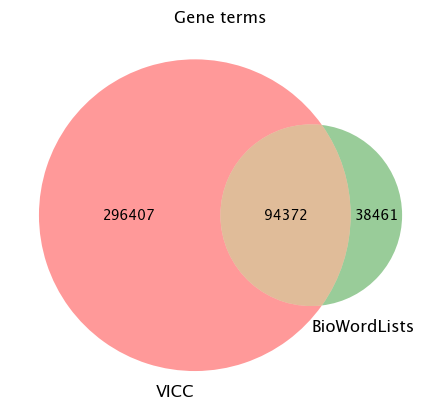

In [156]:
vicc_genes_min_map, vicc_genes_min_terms = get_terms(
    "terms_genes_min.csv"
)
vicc_genes_map, vicc_genes_terms = get_terms("terms_genes_full.csv")
wl_genes_map, wl_genes_terms = get_terms("biowordlists/terms_genes.tsv", "\t")

venn2(subsets=(
    len(vicc_genes_min_terms - wl_genes_terms),
    len(wl_genes_terms - vicc_genes_min_terms),
    len(wl_genes_terms & vicc_genes_min_terms)
), set_labels=("VICC", "BioWordLists"))
plt.title("Gene terms")
plt.show()

In [161]:
[i for i in wl_genes_map if 'pr domain 9' in wl_genes_map[i][1]]

['HGNC:13994']

In [162]:
vicc_genes_min_map['hgnc:13994']

['PRDM9',
 ['meisetz',
  'pr/set domain 9',
  'kmt8b',
  'znf899',
  'prdm9',
  '2.1.1.43',
  'msbp3',
  'meisetz',
  'pfm6']]

In [159]:
{i for i in wl_genes_terms - vicc_genes_min_terms if "gene" not in i}

{'long intergenic non-protein coding rna 846',
 'chromosome x open reading frame 13',
 'centrosomal protein 192kda',
 'dep domain containing 2',
 'pr domain 9',
 'cyclin d1 (prad1: parathyroid adenomatosis 1)',
 'signal-transducing guanine nucleotide-binding regulatory protein beta subunit',
 'met18 homolog (s. cerevisiae)',
 'kindlin-2',
 'dual specificity tyrosine-(y)-phosphorylation regulated kinase 4',
 'tryptase ii',
 'muscle-specific regulatory factor 4',
 'ubiquitin-conjugating enzyme e2e 1',
 'family with sequence similarity 92 member a1',
 'synaptonemal complex protein 2-like',
 'tal1 (scl) interrupting locus',
 'chromosome 14 open reading frame 36',
 'cop9 constitutive photomorphogenic homolog subunit 4 (arabidopsis)',
 'rab6 interacting protein 1',
 'nsfl1 (p97) cofactor (p47)',
 'leukocyte-associated immunoglobulin-like receptor 2',
 'fibronectin type iii domain containing 2',
 'lysine (k)-specific methyltransferase 2a',
 'butyryl coenzyme a synthetase 1',
 '14-3-3 alpha',
